In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision import transforms


In [2]:
data = pd.read_csv('../data/creditcard.csv')
df = pd.DataFrame(data) 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
number_fraud = len(data[data.Class == 1])
number_no_fraud = len(data[data.Class == 0])
print('Number of frauds: ', number_fraud,'\nNumbers of no frauds: ', number_no_fraud)

Number of frauds:  492 
Numbers of no frauds:  284315


In [4]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df_honest = df.query('Class == 0').sample(20000)
df_fraud = df.query('Class == 1').sample(400)
df = pd.concat([df_honest, df_fraud])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [88]:
class AE(torch.nn.Module):
    def __init__(self) -> None:
        super(AE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(29, 14),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(14, 7),
            torch.nn.LeakyReLU()
            )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(7, 14),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(14, 29),
            torch.nn.LeakyReLU()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

model = AE().cpu()
epochs = 100
batch_size = 32
lr = 1e-3
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [42]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#print(len(train_loader), 'train batches')
#print(len(test_loader), 'test batches')

In [89]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

for epoch in range(epochs):
    h = np.array([])
    for (data_epoch, _) in train_loader:
        output = model(data_epoch)
        loss = loss_function(output, data_epoch)
        h = np.append(h, loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, epochs, mean_loss))
    history['train_loss'].append(mean_loss)

torch.save(model.state_dict, './fraud_model_ae.pth')

epoch [1/100], loss:1.3661
epoch [2/100], loss:1.2195
epoch [3/100], loss:1.0546
epoch [4/100], loss:0.9813
epoch [5/100], loss:0.9588
epoch [6/100], loss:0.9435
epoch [7/100], loss:0.9532
epoch [8/100], loss:0.9276
epoch [9/100], loss:0.9325
epoch [10/100], loss:0.9266
epoch [11/100], loss:0.9259
epoch [12/100], loss:0.9310
epoch [13/100], loss:0.9134
epoch [14/100], loss:0.9145
epoch [15/100], loss:0.9133
epoch [16/100], loss:0.9001
epoch [17/100], loss:0.8926
epoch [18/100], loss:0.8949
epoch [19/100], loss:0.8832
epoch [20/100], loss:0.8734
epoch [21/100], loss:0.8748
epoch [22/100], loss:0.8731
epoch [23/100], loss:0.8599
epoch [24/100], loss:0.8609
epoch [25/100], loss:0.8427
epoch [26/100], loss:0.8358
epoch [27/100], loss:0.8313
epoch [28/100], loss:0.8329
epoch [29/100], loss:0.8132
epoch [30/100], loss:0.8129
epoch [31/100], loss:0.8077
epoch [32/100], loss:0.8065
epoch [33/100], loss:0.7810
epoch [34/100], loss:0.7864
epoch [35/100], loss:0.7804
epoch [36/100], loss:0.7650
e

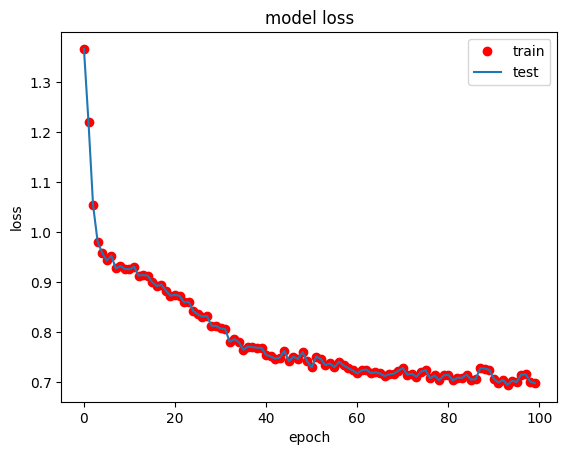

In [90]:
plt.plot(range(epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [97]:
pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for (data,_) in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = loss_function(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
model.train()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=14, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=14, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=14, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=14, out_features=29, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

In [99]:
reconstructionErrorDF.head(5)
print(y_test)

154529    0
89809     0
191716    0
268375    1
220129    0
         ..
40983     0
57615     1
62631     0
255714    0
207983    0
Name: Class, Length: 4080, dtype: int64


In [93]:
print(y_test)
#print(y_train)

154529    0
89809     0
191716    0
268375    1
220129    0
         ..
40983     0
57615     1
62631     0
255714    0
207983    0
Name: Class, Length: 4080, dtype: int64
